# **Setup Environment**

In [1]:
! pip install transformers
! pip install pycaret

In [2]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

# specify GPU
device = torch.device("cuda")

In [3]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set Working Directory - if working on Google Drive
%cd /content/drive/MyDrive/WokeScroll/FakeNews

/content/drive/MyDrive/WokeScroll/FakeNews


# **1. Load and Clean Dataset**

In [5]:
# Read data from csv
true_data = pd.read_csv('True.csv')
fake_data = pd.read_csv('Fake.csv')

# Give each data True/False Labels
true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

# Merge both, shuffle randomly, drop Index column
dataset = pd.concat([true_data, fake_data], ignore_index=True).sample(frac=1).reset_index(drop=True)

print(dataset.shape)
dataset.head()

(44898, 5)


,title,text,subject,date,Target
0,Israel shoots down Iranian-made drone over Syr...,JERUSALEM (Reuters) - Israel shot down a pilot...,worldnews,"September 19, 2017",True
1,"Senator Paul says he, three other Republicans ...",WASHINGTON (Reuters) - Senator Rand Paul said ...,politicsNews,"June 22, 2017",True
2,Putin says question of who hacked Democratic p...,MOSCOW (Reuters) - Russian President Vladimir ...,politicsNews,"December 23, 2016",True
3,MSNBC’S CHRIS MATTHEWS DEFENDS VA SHOOTER: “He...,Chris Matthews tried his best to create sympat...,politics,"Jun 15, 2017",Fake
4,Georgia says suspect in Istanbul airport bombi...,TBILISI (Reuters) - A former Islamic State fig...,worldnews,"December 1, 2017",True


In [6]:
# Add label column, assign 0/1 to true/fake data via one-hot encoding
dataset['label'] = pd.get_dummies(dataset.Target)['Fake'].astype(int)

dataset.head()

,title,text,subject,date,Target,label
0,Israel shoots down Iranian-made drone over Syr...,JERUSALEM (Reuters) - Israel shot down a pilot...,worldnews,"September 19, 2017",True,0
1,"Senator Paul says he, three other Republicans ...",WASHINGTON (Reuters) - Senator Rand Paul said ...,politicsNews,"June 22, 2017",True,0
2,Putin says question of who hacked Democratic p...,MOSCOW (Reuters) - Russian President Vladimir ...,politicsNews,"December 23, 2016",True,0
3,MSNBC’S CHRIS MATTHEWS DEFENDS VA SHOOTER: “He...,Chris Matthews tried his best to create sympat...,politics,"Jun 15, 2017",Fake,1
4,Georgia says suspect in Istanbul airport bombi...,TBILISI (Reuters) - A former Islamic State fig...,worldnews,"December 1, 2017",True,0


([<matplotlib.patches.Wedge at 0x7e66d0e99f90>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

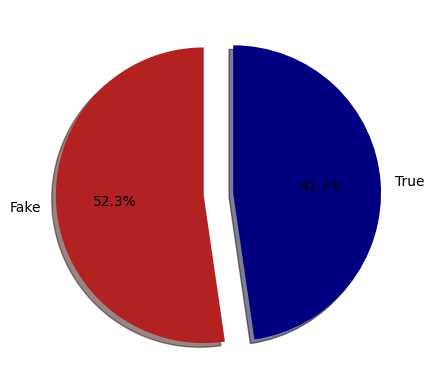

In [7]:
# Check if our data is well balanced
label_size = [dataset['label'].sum(),len(dataset['label'])-dataset['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

# **2. Split the data into train and test sets.**

In [8]:
# Split train data
train_text, temp_text, train_labels, temp_labels = train_test_split(dataset['title'], dataset['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=dataset['Target'])
# Split text and val data
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

Text(0, 0.5, 'Number of texts')

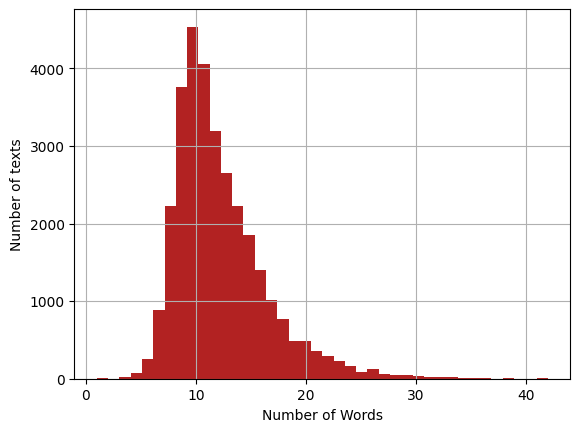

In [9]:
# Histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

# **3. Fine Tune BERT Model.**

-> Prepare Input Data

In [10]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [11]:
# Test out tokenizer functionality
sample_data = ["Building Fake News Detector Model.",
               "Using BERT pre-trained model."]
sample_data_tokenized = tokenizer.batch_encode_plus(sample_data, padding = True)
print(sample_data_tokenized)

{'input_ids': [[101, 2311, 8275, 2739, 19034, 2944, 1012, 102, 0], [101, 2478, 14324, 3653, 1011, 4738, 2944, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [12]:
# From graph, set max length of titles to consider as 20 letters
MAX_LENGTH = 20

# Tokenize train set
train_tokens = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGTH,
    padding = True,
    truncation = True
)

# Tokenize val set
val_tokens = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGTH,
    padding = True,
    truncation = True
)

# Tokenize test set
test_tokens = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGTH,
    padding = True,
    truncation = True
)

In [13]:
# Convert to tensors
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# Convert to tensors
val_seq = torch.tensor(val_tokens['input_ids'])
val_mask = torch.tensor(val_tokens['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# Convert to tensors
test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [14]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

# Train data
train_data = TensorDataset(train_seq, train_mask, train_y)                                  # Wrap the tensors
train_sampler = RandomSampler(train_data)                                                   # Sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size) # dataLoader for train set

# Val data
val_data = TensorDataset(val_seq, val_mask, val_y)                                    # Wrap the tensors
val_sampler = RandomSampler(val_data)                                                 # Sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size) # dataLoader for train set

-> Freeze previous layers in BERT model.

In [15]:
# Do not compute gradient for previously established parameters
for param in bert.parameters():
  param.requires_grad = False

-> Define the model architecture.

In [16]:
from transformers import get_scheduler

class BERT_Architecture(nn.Module):
  def __init__(self, bert):
    super(BERT_Architecture, self).__init__()
    self.bert = bert
    self.dropout = nn.Dropout(0.1)                            # Dropout Layer
    self.relu = nn.ReLU()                                     # Activation Layer
    self.fc1 = nn.Linear(768, 512)                            # Layer 1
    self.fc2 = nn.Linear(512, 2)                              # Layer 2
    self.softmax = nn.LogSoftmax(dim = 1)                     # Softmax Layer

  def forward(self, sent_id, mask):
    cls_hs = self.bert(sent_id, attention_mask = mask)['pooler_output'] # Inputs

    x = self.fc1(cls_hs)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.softmax(x)
    return x

model = BERT_Architecture(bert)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)    # Learning Rate

cross_entropy = nn.NLLLoss()                                  # Loss Function
epochs = 13                                                      # Number of Epochs

<STOPPED AT DEFINE TRAIN & EVALUATE FUNCTION>

# **4. Train the Model.**

In [17]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [18]:
# Train and predict
patience = 2
trigger_times = 0
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model

    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    # Early stopping logic
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'fakenews_model_weights.pt')
        trigger_times = 0  # reset counter
        print(">> Saved best model!")
    else:
        trigger_times += 1
        print(f"!! No improvement. Early stop count: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print(">>> Early stopping triggered.")
            break


 Epoch 1 / 13
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.544
Validation Loss: 0.477
>> Saved best model!

 Epoch 2 / 13
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Bat

# **5. Evaluate the Model.**

In [19]:
# load weights of best model
path = 'fakenews_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [20]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3212
           1       0.92      0.89      0.91      3523

    accuracy                           0.90      6735
   macro avg       0.90      0.91      0.90      6735
weighted avg       0.91      0.90      0.90      6735



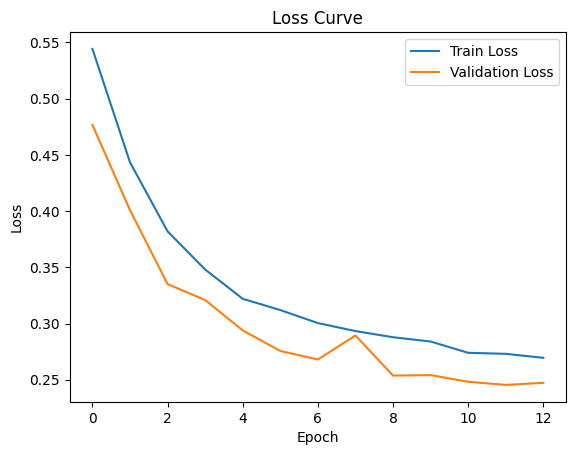

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()


# **6. Test out the Model with new data.**

In [22]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGTH = 20
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGTH,
    padding = True,
    truncation = True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([1, 1, 0, 0])

In [54]:
def predict_news(title: str) -> str:
    """
    Takes a list of news titles and returns a list of predicted labels.
    """
    MAX_LENGTH = 20

    # Tokenize the input titles
    tokens = tokenizer.batch_encode_plus(
        [title],
        max_length=MAX_LENGTH,
        padding=True,
        truncation=True,
        return_tensors='pt'
    )

    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        pred = torch.argmax(outputs, dim=1).item()

    # Convert 0/1 to labels
    return "Fake" if pred == 1 else "True"

In [56]:
title = "Elon Musk apologises for previous tweets about Donald Trump: says he took things too far"

predictions = predict_news(title)
print(predictions)

Fake
